<a href="https://colab.research.google.com/github/k-ganda/auth/blob/master/notebook/Predict_Occupancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pediatric ICU BED DEMAND(OCCUPANCY) FORECASTING

**KEY POINTS ON OUR PROBLEM**

1. **Inputs vs. Outputs:** *What are the inputs and outputs for a forecast?*

```
- Inputs: Historical ICU occupancy
- OutputL Predicted ICU Occupancy.
```

2. **Endogenous vs. Exogenous:** *What are the endogenous and exogenous variables?*

```
- The variables are endogenous, the past occupancy is used to forecast future occupancy.
```

3. **Unstructured vs. Structured:** *Are the time series variables unstructured or structured?*

```
- The variables are structured; numeric and tabular
```

4. **Regression vs. Classification:** *Are you working on a regression or classification predictive modeling* *problem? What are some alternate ways to frame your time series forecasting problem?*

```
- This is a regression modeling problem, predicting numerical values(no of ICU beds in next week)
```

5. **Univariate vs. Multivariate:**  *Are you working on a univariate or multivariate time series problem?*

```
- It is a univariate problem; forecasting only on occupied beds.
```

6. **Single-step vs. Multi-step:** *Do you require a single-step or a multi-step forecast?*

```
- This is a single-step forecast, predicting only the next 1 week of ICU occupancy.
```

7. **Static vs. Dynamic:** *Do you require a static or a dynamically updated model?*

```
- Curently our model is Static but future improvements involve dynamic so it can retrain using new admissions/discharges.
```

8. **Contiguous vs. Discontiguous:** *Are your observations contiguous or discontiguous?*

-




# Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Insert Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading the dataset
df = pd.read_excel('/content/drive/MyDrive/Capstone/Dataset1.xlsx')
df.head()

,_id,date,adult_icu_crci_patients,adult_icu_non_crci_patients,available_adult_icu_beds,total_adult_icu_patients,total_adult_icu_beds,ped_icu_crci_patients,ped_icu_non_crci_patients,available_ped_icu_beds,total_ped_icu_patients,total_ped_icu_beds
0,1645,2020-05-01T00:00:00,236,1210,566,1446,2012,0,56,33,56,89
1,1646,2020-05-02T00:00:00,246,1211,555,1457,2012,0,54,35,54,89
2,1647,2020-05-03T00:00:00,243,1197,572,1440,2012,0,56,33,56,89
3,1648,2020-05-04T00:00:00,243,1252,517,1495,2012,0,59,30,59,89
4,1649,2020-05-05T00:00:00,240,1247,525,1487,2012,0,56,33,56,89


In [4]:
# Columns in our dataset
df.columns

Index(['_id', 'date', 'adult_icu_crci_patients', 'adult_icu_non_crci_patients',
       'available_adult_icu_beds', 'total_adult_icu_patients',
       'total_adult_icu_beds', 'ped_icu_crci_patients',
       'ped_icu_non_crci_patients', 'available_ped_icu_beds',
       'total_ped_icu_patients', 'total_ped_icu_beds'],
      dtype='object')

Our dataset Contains 12 columns.

- The date column is in daily format, we will need to aggregrate it to weekly for our forecasting problem

- The columns relevant to the problem are: Date, available_ped_icu_beds, total_ped_icu_patients which is also the number_of_occupied beds, and the total_ped_icu_beds.

- The reason for using pediatrics data is cause the count is low and can be related to the African context although still too large.

- We can drop the rest of our columns, but first let's understand our dataset but getting the info and general statics.


# Understanding Our Dataset(descriptive statistics and info)

In [5]:
# Dropping columns we won't need
df.drop(['_id', 'adult_icu_crci_patients', 'adult_icu_non_crci_patients',
                 'available_adult_icu_beds', 'total_adult_icu_patients', 'total_adult_icu_beds',
                 'ped_icu_crci_patients', 'ped_icu_non_crci_patients'], axis=1, inplace=True)

In [6]:
# Basic information of our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1651 entries, 0 to 1650
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   date                    1651 non-null   object
 1   available_ped_icu_beds  1651 non-null   int64 
 2   total_ped_icu_patients  1651 non-null   int64 
 3   total_ped_icu_beds      1651 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 51.7+ KB


- We have no null values in all our columns and only the date is an object, the rest are integers.


In [8]:
# Descriptive analysis
df.describe()

,available_ped_icu_beds,total_ped_icu_patients,total_ped_icu_beds
count,1651.000000,1651.000000,1651.000000
mean,38.379770,73.464567,111.844337
std,12.214767,17.965466,18.134263
min,-55.000000,29.000000,89.000000
25%,31.000000,59.000000,93.000000
50%,39.000000,73.000000,109.000000
75%,46.000000,86.000000,131.000000
max,102.000000,186.000000,154.000000


We have 1651 rowss,

- The mean daily occupancy is approximately **73** patients

- The range of icu bed occupancy is from **29 to 186**

- The ICU bed capacity is from 89- 154 beds.

- Let's rename *total_ped_icu_patients* to *occupied_ped_beds*.

In [9]:
# Renaming column total_ped_icu_patients
df.rename(columns={'total_ped_icu_patients': 'occupied_ped_icu_beds'}, inplace=True)

In [10]:
df.head()

,date,available_ped_icu_beds,occupied_ped_icu_beds,total_ped_icu_beds
0,2020-05-01T00:00:00,33,56,89
1,2020-05-02T00:00:00,35,54,89
2,2020-05-03T00:00:00,33,56,89
3,2020-05-04T00:00:00,30,59,89
4,2020-05-05T00:00:00,33,56,89


# Exploratory Data Analysis

- Let's visualise our data to understand the trends, and patterns.



In [11]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Set date index
df = df.set_index('date')

In [12]:
# Sort date values
df = df.sort_values(by='date')

In [13]:
df

,available_ped_icu_beds,occupied_ped_icu_beds,total_ped_icu_beds
date,,,
2020-05-01,33,56,89
2020-05-02,35,54,89
2020-05-03,33,56,89
2020-05-04,30,59,89
2020-05-05,33,56,89
...,...,...,...
2024-11-02,50,83,133
2024-11-03,49,84,133
2024-11-04,45,88,133


In [14]:
occupied_beds_daily_series = df['occupied_ped_icu_beds'].asfreq('D')

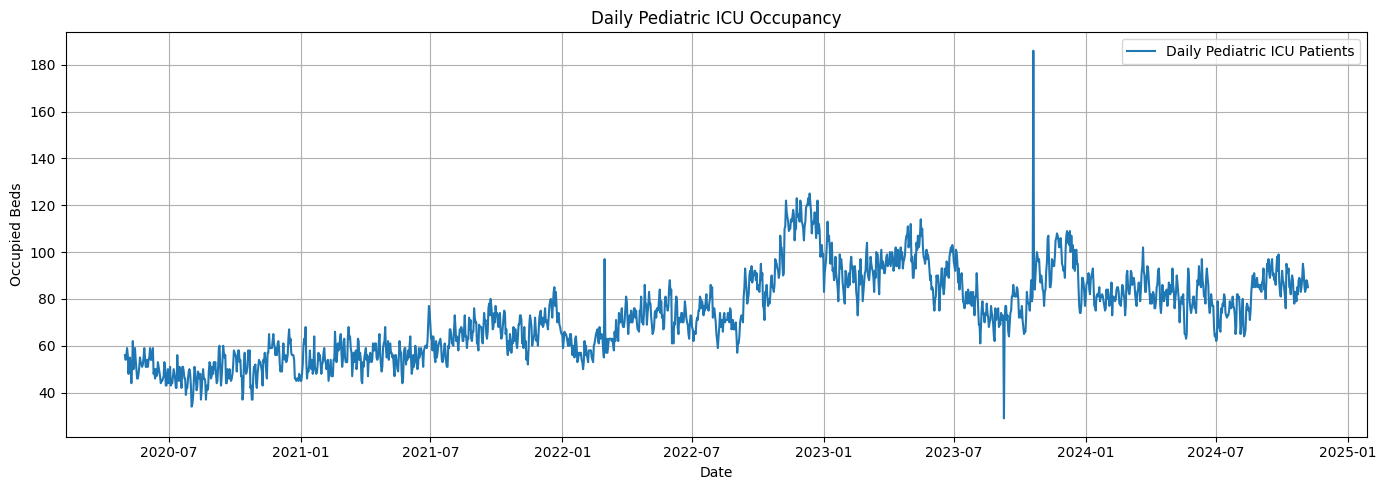

In [ ]:
# Plot daily data - ONLY occupied beds
plt.figure(figsize=(14, 5))
plt.plot(df['occupied_ped_icu_beds'], label='Daily Pediatric ICU Patients') # Plotting only the occupied beds column
plt.title("Daily Pediatric ICU Occupancy")
plt.xlabel("Date")
plt.ylabel("Occupied Beds")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

There is a noticeable increase in bed occupancy from 2020 through early 2023 then followed by a stable decline period.

There are also spikes and dips seen but it is too noisy to detect regular patterns.

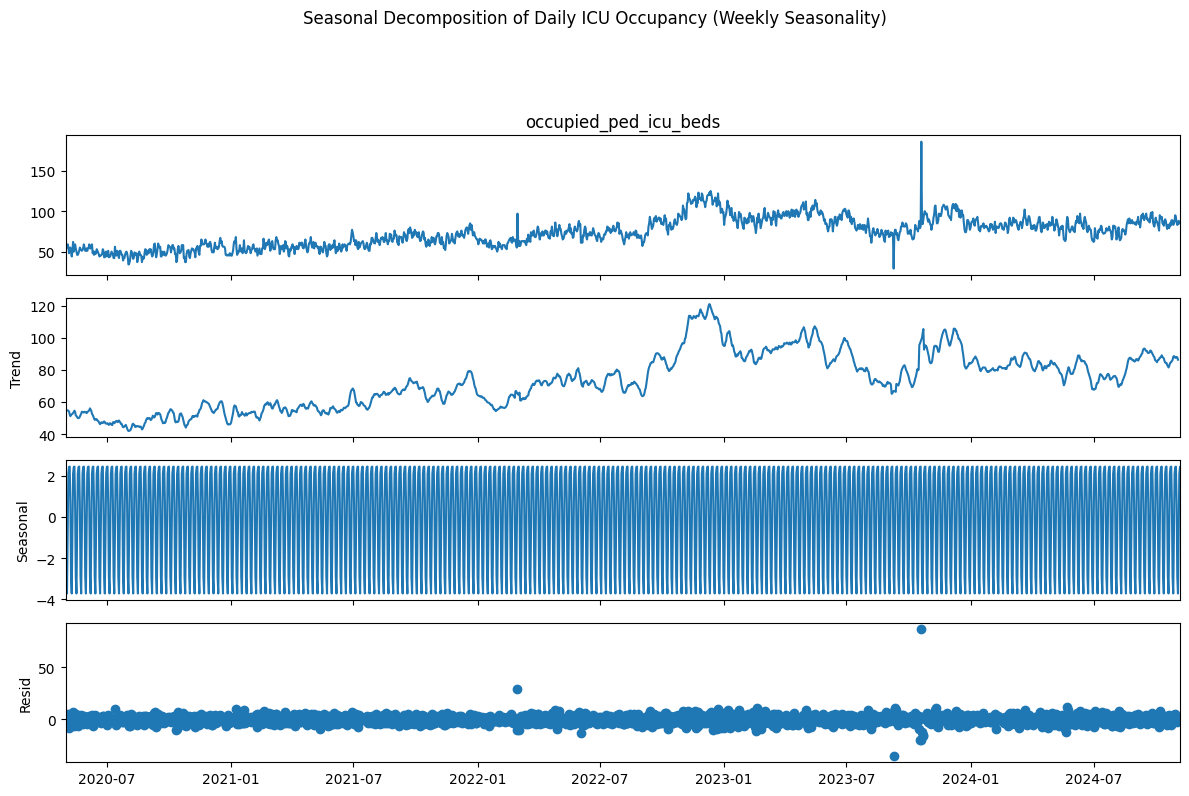

In [ ]:
# Decompose the daily time series to specifically look for a weekly pattern(7 day period)
decomposition_daily_weekly_seasonality = seasonal_decompose(occupied_beds_daily_series, model='additive', period=7)

# Plot the results of the daily decomposition with weekly seasonality
fig_daily_weekly = decomposition_daily_weekly_seasonality.plot()
fig_daily_weekly.set_size_inches(12, 8)
plt.suptitle('Seasonal Decomposition of Daily ICU Occupancy (Weekly Seasonality)', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The above graph shows the trend, seasonality of ICU bed occupancy, It is however too noisy to intergrate, we will aggregate to monthly and weekly and gain insights from it.

## Pediatric ICU Capacity vs. Occupancy Over Time

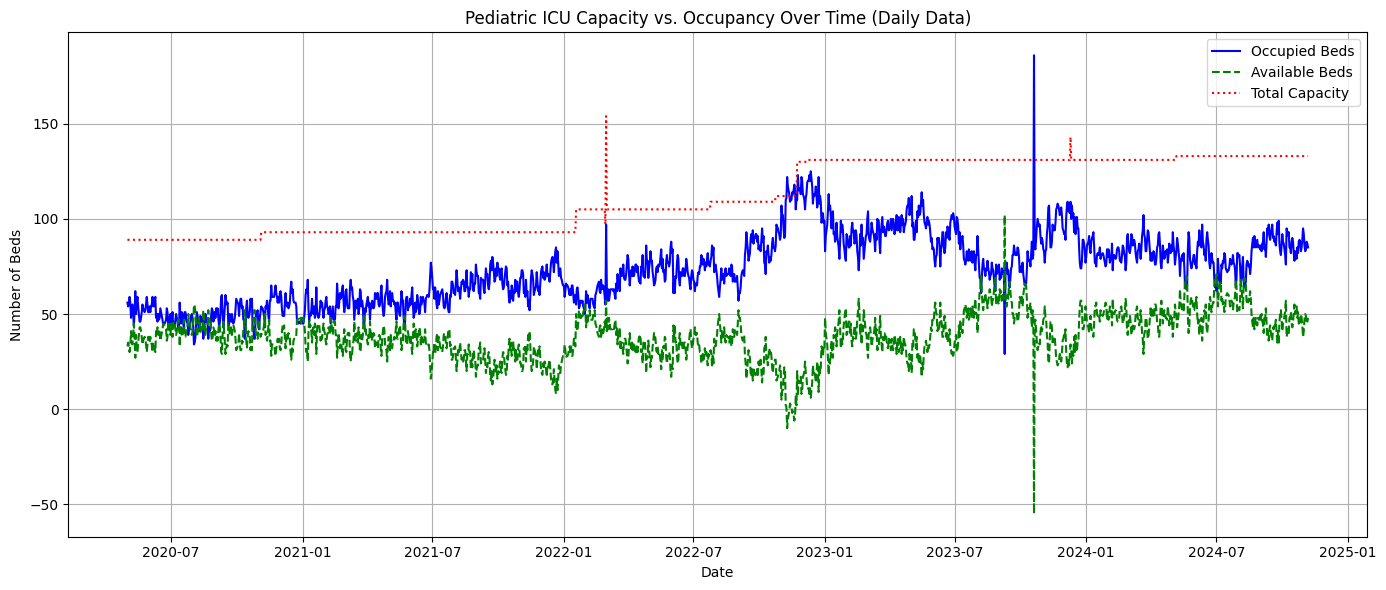

In [29]:
# Plot Capacity vs Occupancy
plt.figure(figsize=(14, 6))

# Plot total occupied beds
plt.plot(df.index, df['occupied_ped_icu_beds'], label='Occupied Beds', color='blue')

# Plot available beds
plt.plot(df.index, df['available_ped_icu_beds'], label='Available Beds', color='green', linestyle='--')

# Plot total beds
plt.plot(df.index, df['total_ped_icu_beds'], label='Total Capacity', color='red', linestyle=':')

plt.title("Pediatric ICU Capacity vs. Occupancy Over Time (Daily Data)")
plt.xlabel("Date")
plt.ylabel("Number of Beds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



This plot visualizes the daily trends in pediatric ICU bed occupancy relative to available beds and total capacity.

- The **blue line** represents the **Occupied Beds**, showing the daily number of pediatric ICU patients.
- The **green dashed line** represents the **Available Beds**, indicating the number of empty beds.
- The **red dotted line** represents the **Total Capacity**, showing the maximum number of pediatric ICU beds.

From this plot, we can observe:

- A data anomaly was identified where **occupied beds temporarily exceeded total capacity.** We will correct this by capping occupied beds at the total capacity for the affected days.

- Assuming total capacity remains constant, there is an **inverse relationship** between occupied and available beds. As the number of Occupied Beds increases, the number of Available Beds generally decreases. Conversely, as Occupied Beds decrease, Available Beds tend to increase.

- The plot also shows that the Total Capacity has changed over the observed period, which directly impacts the number of available beds (Available Beds = Total Capacity - Occupied Beds).

- Periods where occupied beds are close to or equal to total capacity (and available beds are close to zero), highlighting periods of high utilization or potential strain on resources.

# Check for Anomalies( Where occupied beds exceeds the total beds)

In [31]:
# Check anomaly where occupied beds exceed total capacity
anomalies = df[df['occupied_ped_icu_beds'] > df['total_ped_icu_beds']]
anomalies

,available_ped_icu_beds,occupied_ped_icu_beds,total_ped_icu_beds
date,,,
2022-11-09,-10,122,112
2022-11-10,-5,117,112
2022-11-11,-3,115,112
2022-11-12,-1,113,112
2022-11-16,-2,114,112
2022-11-17,-1,113,112
2022-11-18,-3,115,112
2022-11-19,-6,118,112
2022-11-20,-4,116,112


In [32]:
# We will cap those anomalies at total_ped_icu_beds
df.loc[anomalies.index, 'occupied_ped_icu_beds'] = df.loc[anomalies.index, 'total_ped_icu_beds']

# Weekly Occupancy Vs Capacity after capping

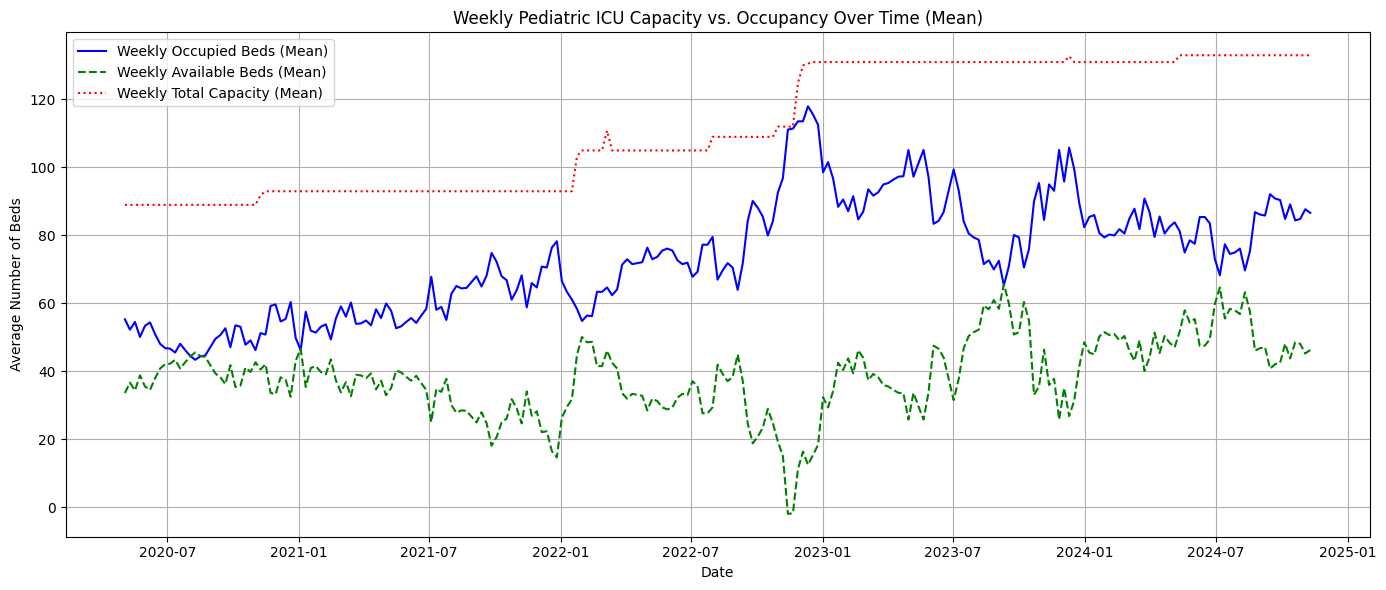

In [43]:
# Resample the relevant daily data to weekly frequency (mean)
weekly_capacity_occupancy = df[['occupied_ped_icu_beds', 'available_ped_icu_beds', 'total_ped_icu_beds']].resample('W').mean()

# Plot Weekly Capacity vs Occupancy
plt.figure(figsize=(14, 6))

# Plot weekly occupied beds
plt.plot(weekly_capacity_occupancy.index, weekly_capacity_occupancy['occupied_ped_icu_beds'], label='Weekly Occupied Beds (Mean)', color='blue')

# Plot weekly available beds
plt.plot(weekly_capacity_occupancy.index, weekly_capacity_occupancy['available_ped_icu_beds'], label='Weekly Available Beds (Mean)', color='green', linestyle='--')

# Plot weekly total beds
plt.plot(weekly_capacity_occupancy.index, weekly_capacity_occupancy['total_ped_icu_beds'], label='Weekly Total Capacity (Mean)', color='red', linestyle=':')

plt.title("Weekly Pediatric ICU Capacity vs. Occupancy Over Time (Mean)")
plt.xlabel("Date")
plt.ylabel("Average Number of Beds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The plot visualizes the **weekly average** trends in pediatric ICU bed occupancy relative to available beds and total capacity.

By **aggregating the daily data to a weekly frequency**, some of the day-to-day noise is smoothed out, making it easier to observe longer-term patterns.

- The **blue line** represents the **Weekly Average Occupied Beds**, showing the average number of pediatric ICU patients per week.
- The **green dashed line** represents the **Weekly Average Available Beds**, indicating the average number of empty beds per week.
- The **red dotted line** represents the **Weekly Average Total Capacity**, showing the average maximum number of pediatric ICU beds per week.

From this weekly plot, we can observe:

- As the Weekly Average Occupied Beds increases, the Weekly Average Available Beds generally decreases, and vice versa, reflecting the inverse relationship (Available Beds = Total Capacity - Occupied Beds).


- Changes in the weekly average total capacity of pediatric ICU beds over the observed period( early 2023).

- Periods where the average occupied beds are close to the average total capacity (and average available beds are close to zero), highlighting weeks of consistently high utilization or potential strain on resources. This indicates times when the ICU was operating near its capacity. Seen in early 2023


In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [35]:
# Resample weekly and monthly frequency
weekly_series = occupied_beds_daily_series.resample('W').mean()
monthly_series = occupied_beds_daily_series.resample('ME').mean()

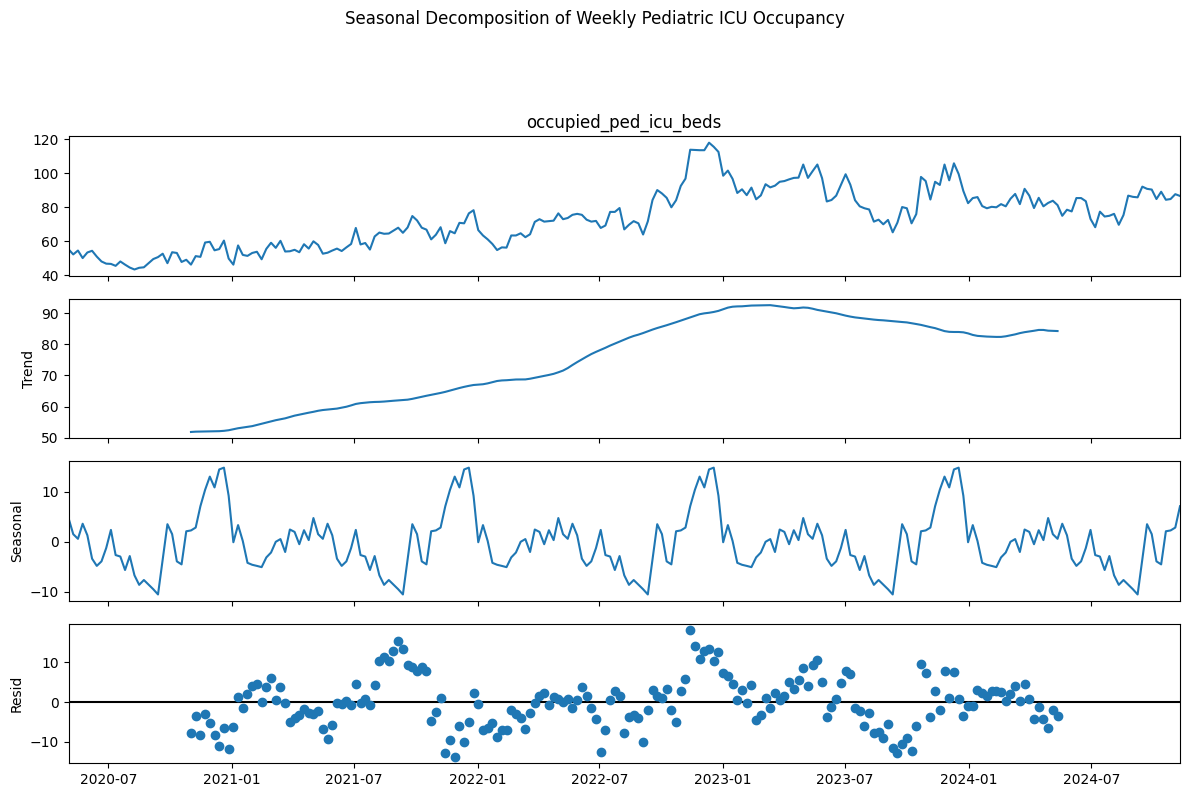

In [36]:
# Perform seasonal decomposition on the weekly time series using an additive model
decomposition_weekly = seasonal_decompose(weekly_series, model='additive')

# Perform seasonal decomposition on the monthly time series using an additive model
decomposition_monthly = seasonal_decompose(monthly_series, model='additive')

# Plot the results of the weekly seasonal decomposition
fig_weekly = decomposition_weekly.plot()
fig_weekly.set_size_inches(12, 8)
plt.suptitle('Seasonal Decomposition of Weekly Pediatric ICU Occupancy', y=1.02) # Add a main title to the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

There is some seasonal trends in weekly ICU occupancy.

There are short cycles and flactuactions but patterns are less regular.

this likely appears due to local outbreaks.




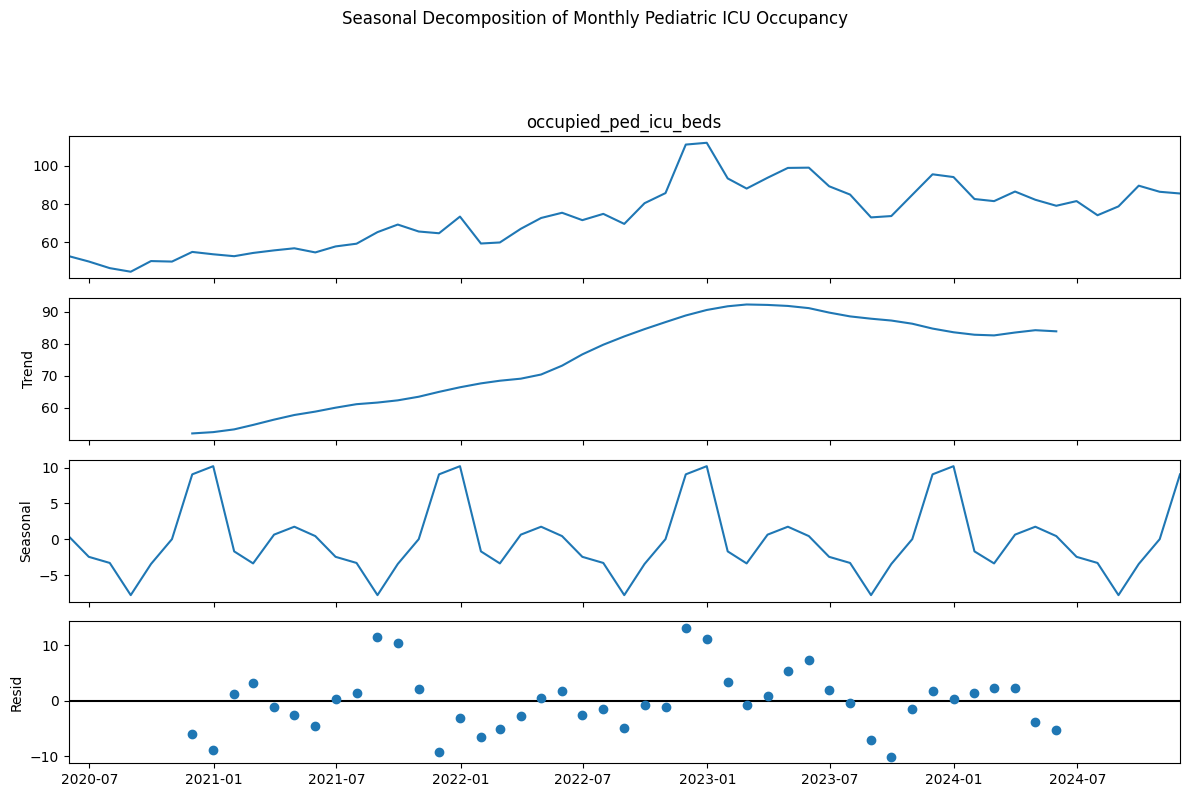

In [37]:
# --- Seasonal Decomposition for Monthly Series ---
# Decompose the monthly series (looking for yearly seasonality within monthly data)
decomposition_monthly = seasonal_decompose(monthly_series, model='additive') # period defaults to 12 for monthly data

fig_monthly = decomposition_monthly.plot()
fig_monthly.set_size_inches(12, 8)
plt.suptitle('Seasonal Decomposition of Monthly Pediatric ICU Occupancy', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

There is a strong seasonal pattern in ICU occupancy monthly. ICU occupancy rises and falls at similar times each year.

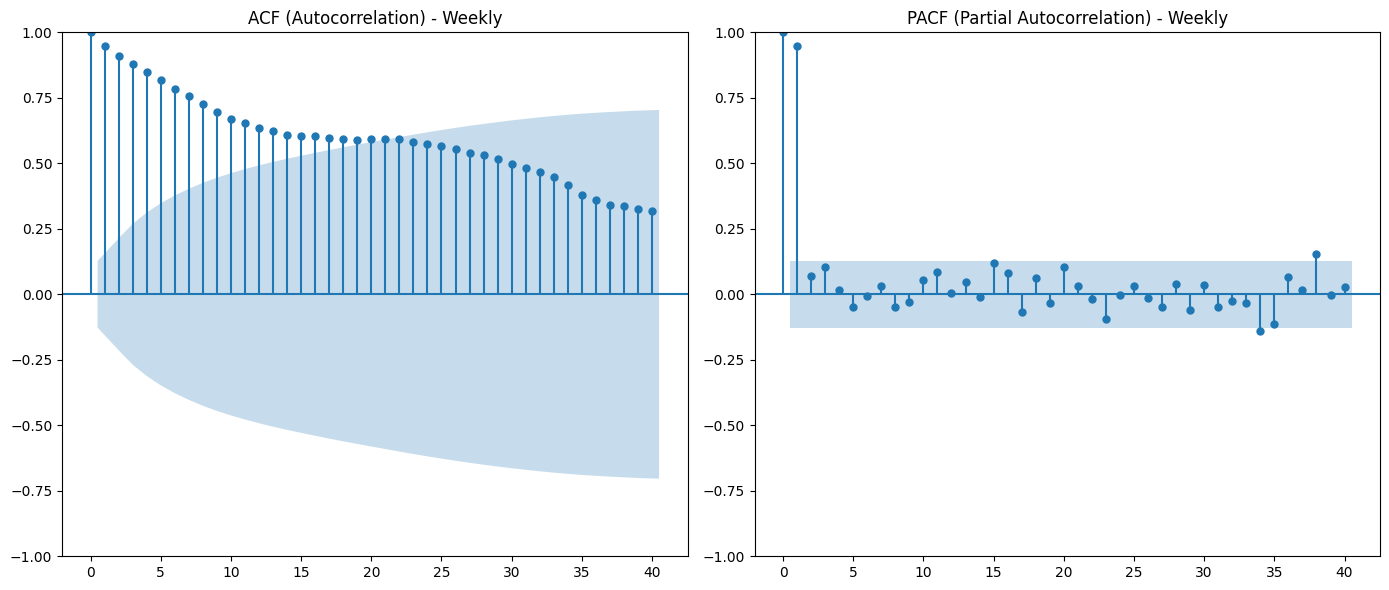

In [38]:
# Plot ACF and PACF for the weekly series
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
# Plot Autocorrelation Function (ACF) for the weekly time series
plot_acf(weekly_series, ax=plt.gca(), lags=40)
plt.title("ACF (Autocorrelation) - Weekly")

plt.subplot(1, 2, 2)
# Plot Partial Autocorrelation Function (PACF) for the weekly time series
plot_pacf(weekly_series, ax=plt.gca(), lags=40, method='ywm')
plt.title("PACF (Partial Autocorrelation) - Weekly")

plt.tight_layout()
plt.show()

The Autocorrelation function shows how the current value in the time series is correlated with the past values(lags)

All the lags have a high positive correlation. This suggests that values this week are highly dependent on previus weeks.

The values decay gradually indicating a trend with no clear spikes.

The ACF does not cut off sharply — instead, it tails off gradually. This is typical of **non-stationary** time series (i.e., the mean and variance change over time) and make require differencing to make it stationary for modeling.

PACF isolates the direct effect of a past value on the current value (i.e., it removes indirect influences from intermediate lags).

Big spike at lag 1, then all other lags are small and mostly within the confidence interval (the blue shaded region).This suggests that the direct relationship is mostly with the previous week, and other weeks do not directly influence the current week as much.



# Check for Stationarity

In [39]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(weekly_series)

# Print the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the result
if result[1] <= 0.05:
    print("\nReject the null hypothesis (H0), the time series is stationary.")
else:
    print("\nFail to reject the null hypothesis (H0), the time series is non-stationary.")

ADF Statistic: -1.985897
p-value: 0.292791
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573

Fail to reject the null hypothesis (H0), the time series is non-stationary.


We have confirmed that our time series is non-stationary, before we build our first ARIMA model, we will need to perform differencing as most time series models including ARIMA require stationarity.


# Differencing

Transformation applied to make time series stationary.

We will perform first order differencing and rerun the ADF to see if it is stationary



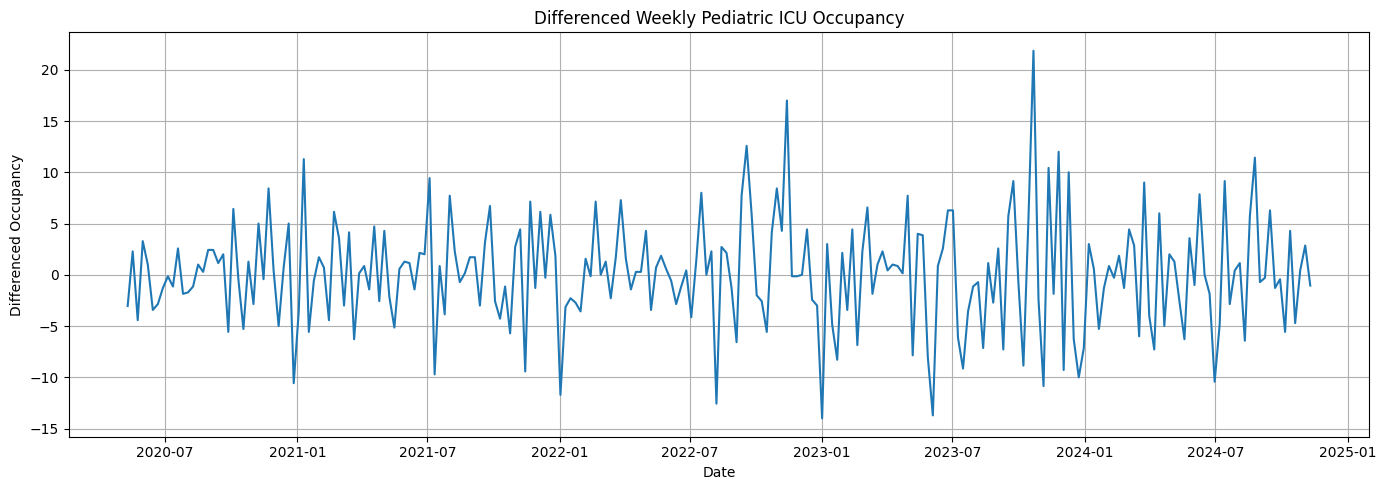


ADF Statistic (Differenced Series): -12.840317
p-value (Differenced Series): 0.000000
Critical Values (Differenced Series):
	1%: -3.459
	5%: -2.874
	10%: -2.573

Reject the null hypothesis (H0), the differenced time series is stationary.


In [40]:
# Perform first-order differencing
weekly_series_diff = weekly_series.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(14, 5))
plt.plot(weekly_series_diff)
plt.title("Differenced Weekly Pediatric ICU Occupancy")
plt.xlabel("Date")
plt.ylabel("Differenced Occupancy")
plt.grid(True)
plt.tight_layout()
plt.show()

# Perform ADF test on the differenced series to confirm stationarity
result_diff = adfuller(weekly_series_diff)

print('\nADF Statistic (Differenced Series): %f' % result_diff[0])
print('p-value (Differenced Series): %f' % result_diff[1])
print('Critical Values (Differenced Series):')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

if result_diff[1] <= 0.05:
    print("\nReject the null hypothesis (H0), the differenced time series is stationary.")
else:
    print("\nFail to reject the null hypothesis (H0), the differenced time series is non-stationary.")

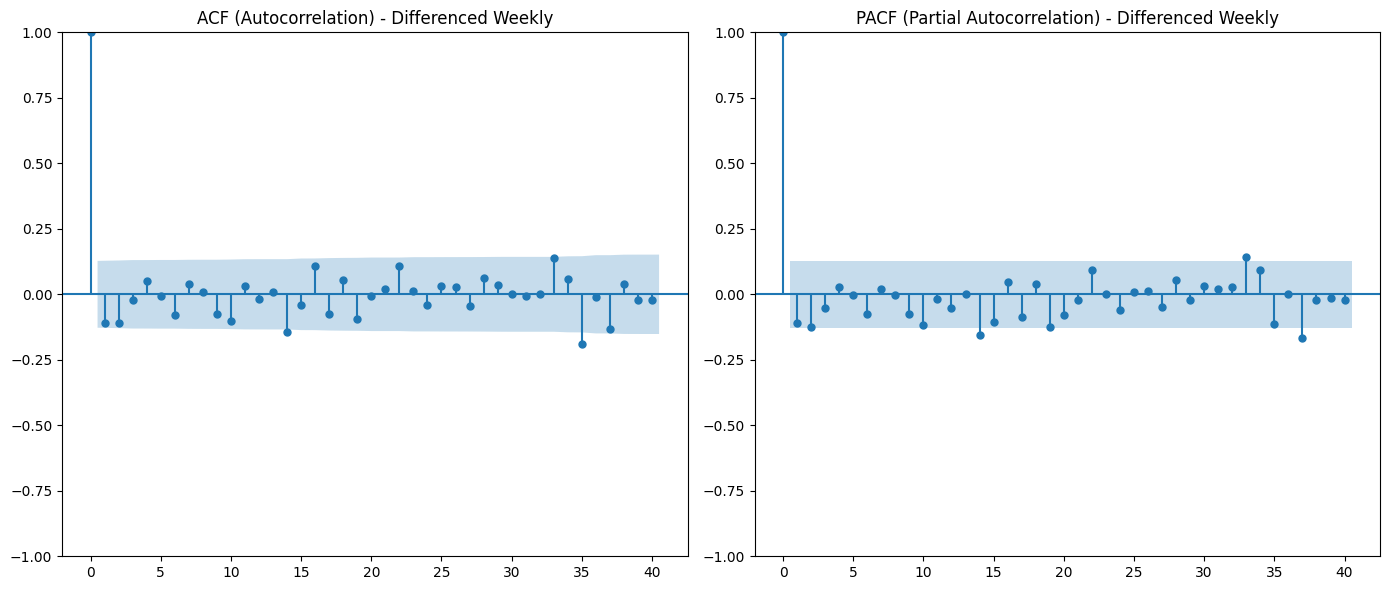

In [41]:
# Plot ACF and PACF for the differenced weekly series
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(weekly_series_diff, ax=plt.gca(), lags=40)
plt.title("ACF (Autocorrelation) - Differenced Weekly")

plt.subplot(1, 2, 2)
plot_pacf(weekly_series_diff, ax=plt.gca(), lags=40, method='ywm')
plt.title("PACF (Partial Autocorrelation) - Differenced Weekly")

plt.tight_layout()
plt.show()

Manual dofferencing is done to understand what values are fit pdq for our ARIMA model.

We have alreday determined that d=1 - Because we applied 1st order differencing.

ACF plot shows a significant spike at Lag 1, and then the values quickly drop and mostly fall within the blue shaded confidence interval, suggesting possible Moving Average(q) as 1

PACF also cuts off at 1, so a possible starting point is aso 1.

That's where we will start from in our ARIMA model

# Creating lagged features

This allows us to incorporate the historical patterns and dependencies of the time series into our modeling process, leveraging past values to predict future occupancy.

- Although we won't use them in our ARIMA models since they already incoorporate past values, we will require them for the other models.


In [42]:
# Create lag features (1 to 4 weeks back)
lags = [1, 2, 3, 4]
lagged_df = pd.DataFrame({'y': weekly_series})
for lag in lags:
    lagged_df[f'lag_{lag}'] = weekly_series.shift(lag)

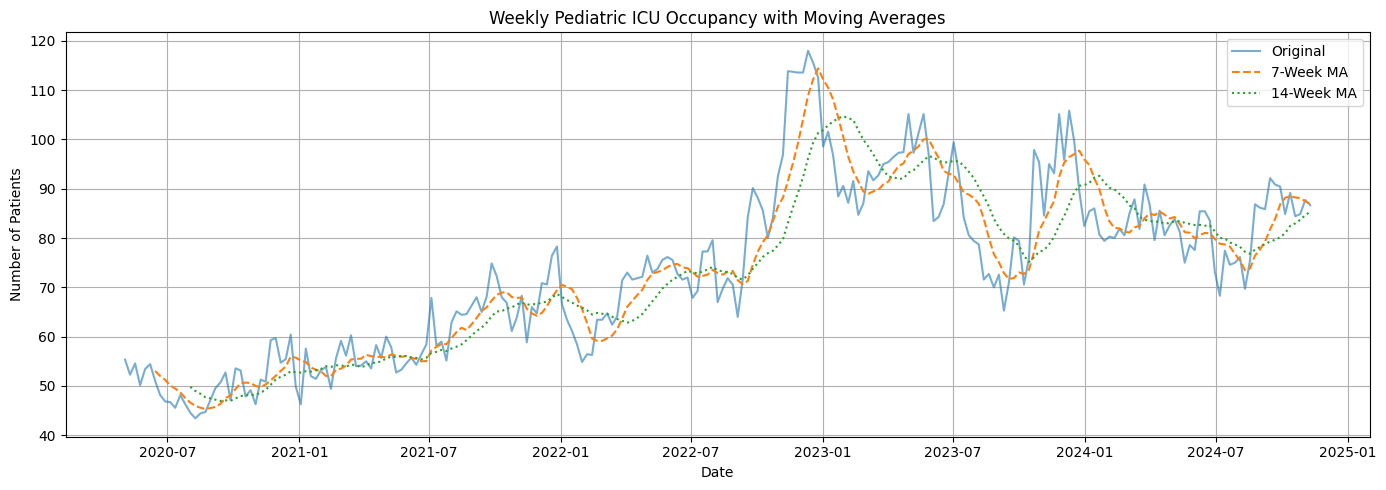

,y,lag_1,lag_2,lag_3,lag_4
date,,,,,
2020-05-31,53.428571,50.142857,54.571429,52.285714,55.333333
2020-06-07,54.428571,53.428571,50.142857,54.571429,52.285714
2020-06-14,51.000000,54.428571,53.428571,50.142857,54.571429
2020-06-21,48.142857,51.000000,54.428571,53.428571,50.142857
2020-06-28,46.857143,48.142857,51.000000,54.428571,53.428571


In [44]:
# Drop NaN values caused by shifting
lagged_df = lagged_df.dropna()

# Moving average smoothing (7 and 14 weeks)
weekly_df = weekly_series.to_frame(name='y')
weekly_df['MA_7'] = weekly_df['y'].rolling(window=7).mean()
weekly_df['MA_14'] = weekly_df['y'].rolling(window=14).mean()

# Plot moving averages
plt.figure(figsize=(14, 5))
plt.plot(weekly_df['y'], label='Original', alpha=0.6)
plt.plot(weekly_df['MA_7'], label='7-Week MA', linestyle='--')
plt.plot(weekly_df['MA_14'], label='14-Week MA', linestyle=':')
plt.title("Weekly Pediatric ICU Occupancy with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Number of Patients")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lagged_df.head()

# Correlation Matrix of Weekly Pediatric ICU Occupancy and Lagged Values

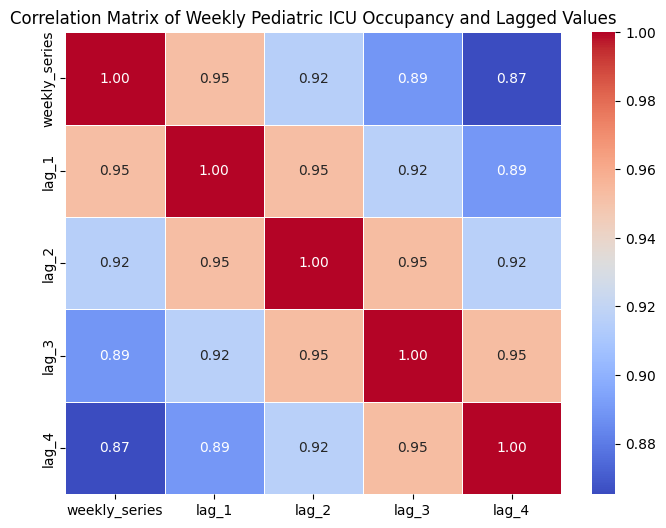

In [30]:
# Create a DataFrame with the weekly series and its lags
weekly_series_corr_df = pd.DataFrame({'weekly_series': weekly_series})
lags_for_corr = [1, 2, 3, 4] # You can adjust the number of lags

for lag in lags_for_corr:
    weekly_series_corr_df[f'lag_{lag}'] = weekly_series_corr_df['weekly_series'].shift(lag)

# Drop rows with NaN values introduced by lagging
weekly_series_corr_df = weekly_series_corr_df.dropna()

# Calculate the correlation matrix
correlation_matrix = weekly_series_corr_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of Weekly Pediatric ICU Occupancy and Lagged Values")
plt.show()



This heatmap illustrates the linear correlation between the weekly average pediatric ICU occupancy and its values from previous weeks (lags).

From this heatmap, we can see:

- Strong positive correlations for the immediate past lags (e.g., `lag_1`, `lag_2`), confirming that recent weekly occupancy is highly predictive of the current week's occupancy.

- The correlation generally decreases as the lag increases, indicating that the relationship weakens with time.

- The diagonal shows perfect correlation (1.00) as it's the correlation of a variable with itself.

This visualization reinforces the time-dependent nature of the data and supports the use of models that leverage past values for forecasting.

# ARIMA Model Building

In [45]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

In [46]:
# Print the number of weeks in the weekly series to how to split
print(f"Total number of weeks in the dataset: {len(weekly_series)}")

Total number of weeks in the dataset: 237


In [47]:
# Train the model on the full dataset then use ARIMA to forecasr 1 week
model = ARIMA(weekly_series, order=(1, 1, 1)) # Baseline model
model_fit = model.fit()

In [48]:
# Print AIC and BIC from the fitted model
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 1450.2244067178635
BIC: 1460.6159021329404



AIC(Akaike Information Criterion) and BIC(Bayesian Information Criterion.)- These are measures to compare different models and help select best model among a set.

We will use these to evaluate the best model of ARIMA's models that we will parameter tune in order to find which model can accurately predict one single datepoint( 1 week forecast)


In [49]:
# Forecast and evaluate
next_week_forecast = model_fit.forecast(steps=1)

print("Forecast for the next week:")
print(next_week_forecast)

Forecast for the next week:
2024-11-17    86.332019
Freq: W-SUN, dtype: float64


Rolling Forecast evaluation


In [17]:
# SPlit into train and test(test with prev 20 weeks)
# For arima we don't manual lag features
train = weekly_series[:-20]
test = weekly_series[-20:]

Week 1/20: Predicted=83.549, Expected=73.143
Week 2/20: Predicted=74.276, Expected=68.286
Week 3/20: Predicted=69.822, Expected=77.429
Week 4/20: Predicted=77.886, Expected=74.571
Week 5/20: Predicted=75.313, Expected=75.000
Week 6/20: Predicted=75.634, Expected=76.143
Week 7/20: Predicted=76.599, Expected=69.714
Week 8/20: Predicted=70.845, Expected=75.429
Week 9/20: Predicted=75.835, Expected=86.857
Week 10/20: Predicted=85.938, Expected=86.143
Week 11/20: Predicted=85.377, Expected=85.857
Week 12/20: Predicted=85.184, Expected=92.143
Week 13/20: Predicted=90.844, Expected=90.857
Week 14/20: Predicted=89.794, Expected=90.429
Week 15/20: Predicted=89.492, Expected=84.857
Week 16/20: Predicted=84.604, Expected=89.143
Week 17/20: Predicted=88.422, Expected=84.429
Week 18/20: Predicted=84.294, Expected=84.857
Week 19/20: Predicted=84.683, Expected=87.714
Week 20/20: Predicted=87.224, Expected=86.667

--- Rolling Forecast Evaluation Metrics ---
MSE: 26.011
RMSE: 5.100
MAE: 3.812
R-squared

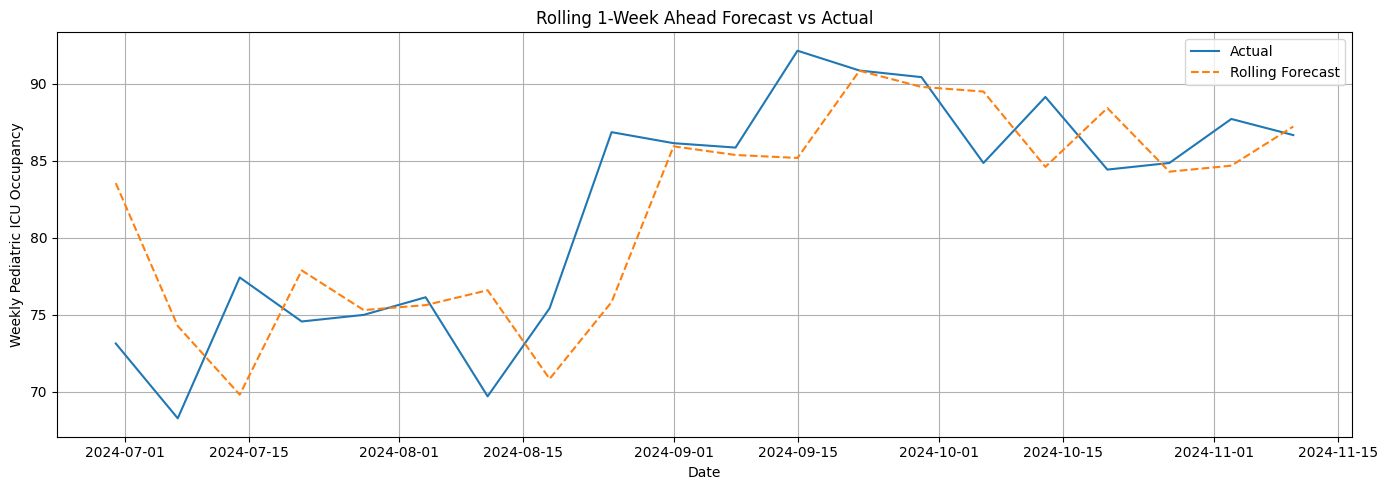

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Define the ARIMA order
arima_order = (1, 1, 1)

# List to store forecasts and actual values
history = [x for x in train] # Start history with the training data
predictions = list()
actuals = list()

# Walk-forward validation
for t in range(len(test)):
    # Fit the model on the historical data (train + previous test data points)
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()

    # Forecast the next step (1-week ahead)
    yhat = model_fit.forecast(steps=1)[0]

    # Store the forecast and the actual value
    predictions.append(yhat)
    actual = test[t]
    actuals.append(actual)

    # Add the actual observation to the history for the next iteration
    history.append(actual)

    print(f'Week {t+1}/{len(test)}: Predicted={yhat:.3f}, Expected={actual:.3f}')

# Evaluate the performance on the rolling forecasts
mse = mean_squared_error(actuals, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)


print('\n--- Rolling Forecast Evaluation Metrics ---')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f"R-squared (R2) Score: {r2}")


# plot the actual vs predicted for the test set
plt.figure(figsize=(14, 5))
plt.plot(test.index, actuals, label='Actual')
plt.plot(test.index, predictions, label='Rolling Forecast', linestyle='--')
plt.title('Rolling 1-Week Ahead Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Weekly Pediatric ICU Occupancy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The rolling forecast evaluation demonstrates the model's ability to predict weekly pediatric ICU occupancy one week ahead.


The lines showing "Predicted" vs. "Expected" for each week demonstrate how the model's 1-week ahead forecasts compare to the actual occupancy over a 20-week test period.

```
The Rolling Forecast Evaluation Metrics (MSE, RMSE, MAE, and R-squared) quantify the accuracy of these predictions.
RMSE (5.100) and MAE (3.812) indicate that, on average, the model's weekly predictions were off by about 3.8 to 5.1 beds.
```

The R-squared score (**0.507**) suggests that the model explains roughly 50.7% of the variation in weekly occupancy during the test period.


The model shows a moderate ability to forecast weekly ICU occupancy.

 The visualization confirms that the forecasts are reasonably close to the actual values.



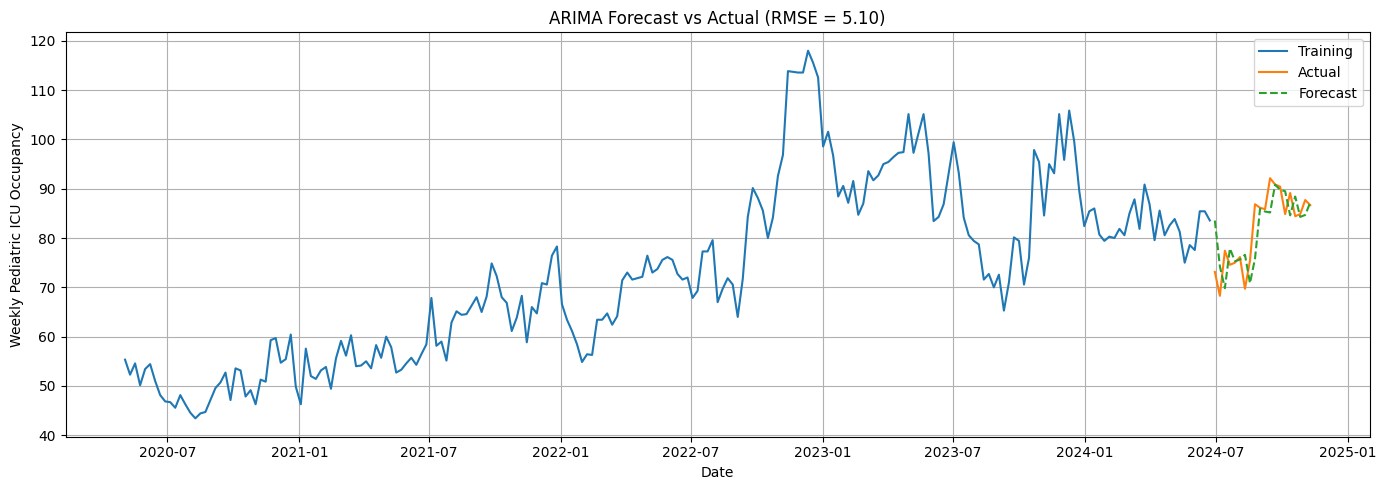

In [ ]:
# Visualization
plt.figure(figsize=(14, 5))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Forecast', linestyle='--')
plt.title(f"ARIMA Forecast vs Actual (RMSE = {rmse:.2f})")
plt.xlabel("Date")
plt.ylabel("Weekly Pediatric ICU Occupancy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Save the first baseline model
model_fit.save('baseline_arima_model.pkl')

# Parameter Tuning

In [ ]:
!pip install tqdm

In [18]:
import warnings
import itertools
from tqdm.auto import tqdm
from statsmodels.tsa.arima.model import ARIMA # Import the ARIMA class

# Temporarily enable warnings to see potential issues
# warnings.filterwarnings("ignore")

# Define parameter ranges for p, d, q
p = d = q = range(0, 3)

# We determined d=1 is likely necessary, but let's include 0 and 2 in the search for robustness
d = range(0, 3)

pdq_combinations = list(itertools.product(p, d, q))

# Store results
results = []
best_aic = float('inf')
best_order = None
best_model = None

# Grid search over ARIMA hyperparameters
# Fit on the training data for tuning
for order in tqdm(pdq_combinations, desc="Fitting ARIMA models"):
    try:

        model = ARIMA(train, order=order)
        model_fit = model.fit()
        aic = model_fit.aic
        results.append((order, aic))

        if aic < best_aic:
            best_aic = aic
            best_order = order

            # store just the best order and AIC

    except Exception as e:
        # Catch errors and print them to understand why fitting failed
        print(f"Error fitting ARIMA model for order {order}: {e}")
        continue # Continue to the next combination even if an error occurs

# Display best order
print(f"\n✅ Best ARIMA order: {best_order} with AIC = {best_aic:.2f}")

# Sort results to see other good models
results_df = pd.DataFrame(results, columns=['Order', 'AIC']).sort_values(by='AIC')
print("\nTop 5 ARIMA Orders by AIC:")
print(results_df.head())

Fitting ARIMA models:   0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



✅ Best ARIMA order: (1, 1, 1) with AIC = 1328.37

Top 5 ARIMA Orders by AIC:
        Order          AIC
13  (1, 1, 1)  1328.370098
5   (0, 1, 2)  1330.403201
4   (0, 1, 1)  1330.535272
21  (2, 1, 0)  1330.585591
12  (1, 1, 0)  1331.304432


To find optimal parameters(p, d, q) for the ARIMA model, a grid search was performed.
Various combinations with defined range were tested(0-3) for each.


Based on the findings, the **best** performing model according to AIC criterion was order (1, 1, 1), with 1328 AIC score.

This indicates that the ARIMA(1, 1, 1) model provides the **best balance** between fitting the training data well and keeping the model relatively simple, compared to the other orders we tested.

**NOTE:** The differencing order (d=1) is **consistent** with our earlier finding that the time series required **first-order differencing** to achieve stationarity.

While (1, 1, 1) was the top choice by AIC, other orders like (0, 1, 2) and (0, 1, 1) also performed well with similarly low AIC scores.



---



**NEXT STEPS**

Our train dataset appears to be too small, we will try to explore data augmentation techniques in time series and see how that affects our model's performance.

- Use the previous 7 days to predict all 7 days in one week.



